In [26]:
from General import functies as functies
from General import classes as classes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


In [48]:
def get_data_from_file(path, meet_I = True):
    file = open(path, 'rt')
    info = file.read().split('\n')[:3]
    file.close()
    datadict = dict()
    for param in info:
        if param != '':
            naam, value = param.split(' = ')
            datadict[naam] = eval(value)
    return datadict.copy()

def remove_bad_datapoints(proef):
    R = proef['R']
    T = proef['T']
    Tnew = []
    Rnew = []
    for indx in range(len(T)):
        if not (T[indx] > 125 and R[indx] < 5000):
            Tnew.append(T[indx])
            Rnew.append(R[indx])
    
    proef['T'] = Tnew.copy()
    proef['R'] = Rnew.copy()
    #use semantics of python

def rescale_temp(T):
    'input: T as a list; output: T as a list where our flawed code is corrected'
    #calculate Pt-resistance:
    (x1, y1) = (18.49, 73.15)
    (x2, y2) = (31.32, 103.15)
    rico = (y2-y1)/(x2-x1)
    weerstanden = [(temp-y1)/rico + x1 for temp in T]
    Tnew = []

    for resistance in weerstanden:
        Tnew.append(((resistance/100 - 1) * 255.86572669) + 273.15) #their temperature 
    return np.array(Tnew.copy())

def plot_const_Temp(proef, mode = 'Voltage', nulspanning = 2.6, ylogscale = False, correct_temp = True, measured_T = True): #input: een proef (= dictionary) #constante temperatuur
    #hierin: alle spanningen in microvolts!
    stroomgemeten = True
    I = np.array(proef['I'])
    V = np.array(proef['V'])*1e6 - nulspanning #de nulspanning eraf trekken
    if measured_T:
        T = np.array(proef['T'])
        if correct_temp:
            T = np.array(rescale_temp(T))
    R = V/I #micro-ohm
    #check whether temperature is approximately constant
    titel = mode + ' as a function of current'
    if measured_T:
        Tmean = round(np.mean(T),4)
        Tsd = round(np.sqrt(np.var(T)),4)
        titel += '; T = ('+str(Tmean) +' $\\pm$ ' + str(Tsd) + ') K'
    #plot it
    fig, ax = plt.subplots(1,1)
    if mode == 'Voltage':
        plotparam = V
    elif mode == 'Resistance':
        plotparam = R
    ax.errorbar(I, plotparam, fmt = 'o')
    ax.set_xlabel('Current [A]')
    if mode == 'Voltage':
        ax.set_ylabel('Voltage [µV]')
    elif mode == 'Resistance':
        ax.set_ylabel('Resistance [$µ\\Omega$]')
    if ylogscale:
        plt.yscale('log')
    ax.set_title(titel)
    plt.tight_layout()
    plt.show()

def plot_const_current(proef, mode = 'Resistance', nulspanning = 2.6, ylogscale = False, correct_temp = True): #input: een proef (= dictionary)
    #hierin: alle spanningen in microvolts!
    stroomgemeten = False
    if 'I' in proef.keys():
        stroomgemeten = True
        I = np.array(proef['I'])
    if 'V' in proef.keys():
        V = np.array(proef['V'])*1e6 - nulspanning #de nulspanning eraf trekken
    T = np.array(proef['T'])
    if correct_temp:
        T = rescale_temp(T)
    if stroomgemeten:
        R = V/I #micro-ohm
    else:
        if 'R' in proef.keys():
            R = np.array(proef['R'])*1e6 #micro-ohm
    #check whether temperature is approximately constant
    titel = mode + ' as a function of temperature'
    if stroomgemeten:
        Imean = round(np.mean(I),4)
        Isd = round(np.sqrt(np.var(I)),4)
        titel += '; I = ('+str(Imean) +' $\\pm$ ' + str(Isd) + ') A'
    #plot it
    fig, ax = plt.subplots(1,1, figsize = (12,6))
    if mode == 'Voltage':
        plotparam = V
    elif mode == 'Resistance':
        plotparam = R
    ax.errorbar(T, plotparam, fmt = 'o')
    ax.set_xlabel('Temperature [K]')
    if mode == 'Voltage':
        ax.set_ylabel('Voltage [µV]')
    elif mode == 'Resistance':
        ax.set_ylabel('Resistance [$µ\\Omega$]')
    if ylogscale:
        plt.yscale('log')
    ax.set_title(titel)
    plt.tight_layout()
    plt.show()

def plot_const_multiple_Temp(proeven, temps, mode = 'Voltage', nulspanning = 2.6, ylogscale = False, correct_temp = True, figsize = (5,5), xlim = (None, None), ylim = (None, None)): #input: een lijst proeven (= dictionary) #constante temperatuur
    #hierin: alle spanningen in microvolts!
    fig, ax = plt.subplots(1,1, figsize = figsize)
    n_lines = len(proeven)
    cmap = mpl.colormaps['plasma']

    # Take colors at regular intervals spanning the colormap.
    colors = cmap(np.linspace(0, 1, n_lines))
    for indx in range(len(proeven)):
        proef = proeven[indx]
        stroomgemeten = True
        I = np.array(proef['I'])
        V = np.array(proef['V'])*1e6 - nulspanning #de nulspanning eraf trekken
        #check whether temperature is approximately constant
        titel = mode + ' as a function of current'

        #plot it
        if mode == 'Voltage':
            plotparam = V
        elif mode == 'Resistance':
            R = V/I #micro-ohm
            plotparam = R
        ax.errorbar(I, plotparam, fmt = 'o', label = str(temps[indx]) + 'K',color = colors[indx])
    ax.set_xlabel('Current [A]', fontsize = 30)
    if mode == 'Voltage':
        ax.set_ylabel('Voltage [µV]', fontsize = 30)
    elif mode == 'Resistance':
        ax.set_ylabel('Resistance [$µ\\Omega$]', fontsize = 30)
    if ylogscale:
        plt.yscale('log')
    ax.set_title(titel, fontsize = 42)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc = 'upper left', fontsize = 30)
    plt.tight_layout()
    plt.show()

def concatenate_experiments(experimenten, parameters = ['V', 'T', 'I']): #input: een lijst met experimenten, elk als dictionary
    geconcateneerd = dict()
    for parameter in parameters:
        geconcateneerd[parameter] = []
    params = geconcateneerd.keys()
    for experiment in experimenten:
        for param in params:
            geconcateneerd[param] += experiment[param]
    return geconcateneerd



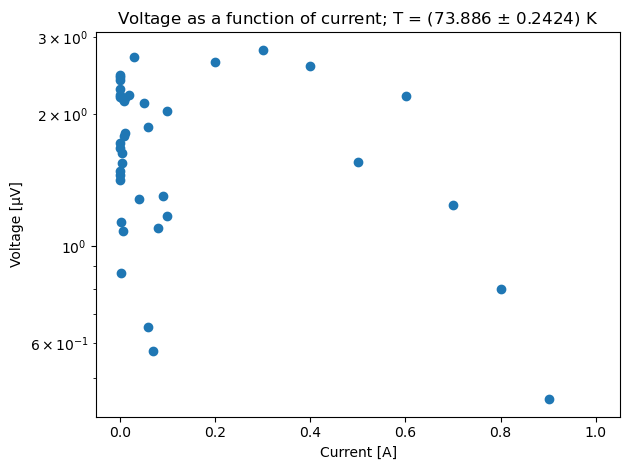

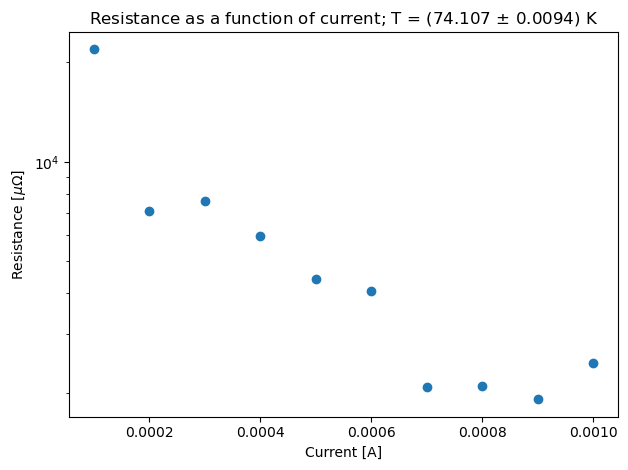

In [28]:
proef_5 = get_data_from_file('data_superconductor/test5.txt')

adres = lambda i : 'data_superconductor/test'  + str(i) + '.txt'
proeven_reeks_1_const_T = concatenate_experiments([get_data_from_file(adres(i)) for i in range(1,6)])



#volledig reeks 1
plot_const_Temp(proeven_reeks_1_const_T, 'Voltage', nulspanning=0, ylogscale=True)
#enkel proef 5 (kleinste orde)
plot_const_Temp(proef_5, 'Resistance', nulspanning = 0, ylogscale=True)

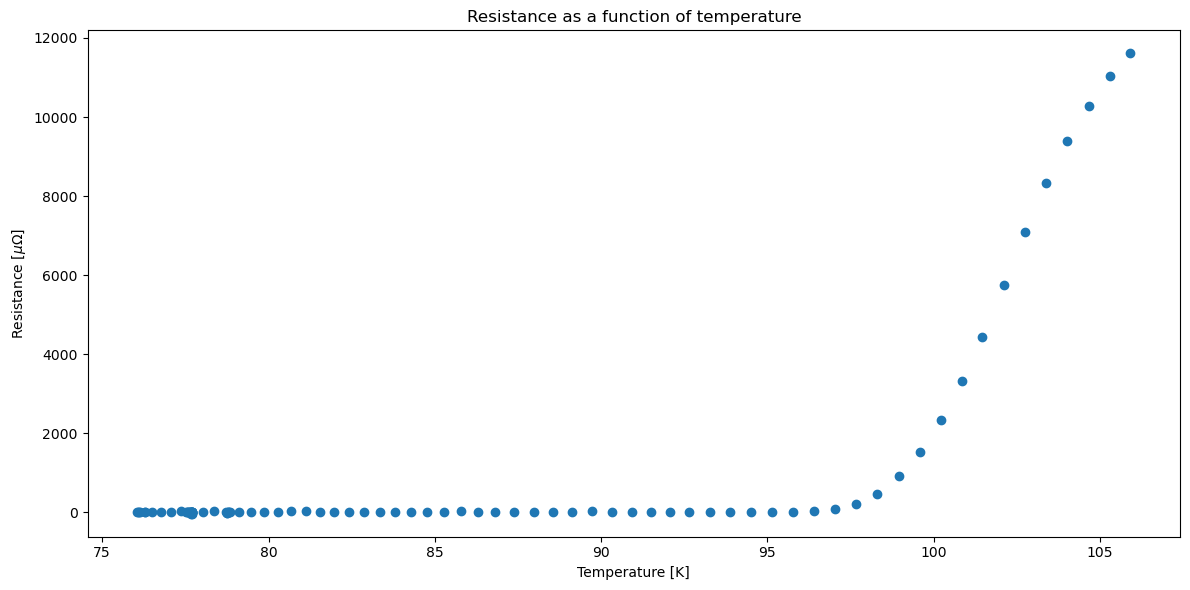

In [29]:
adres = lambda i : 'data_superconductor/R_T_testing'  + str(i) + '.txt'
proeven_reeks_1_const_I = concatenate_experiments([get_data_from_file(adres(i)) for i in range(1,4)], parameters = ['R', 'T'])

plot_const_current(proeven_reeks_1_const_I, ylogscale = False)


rescaled temp


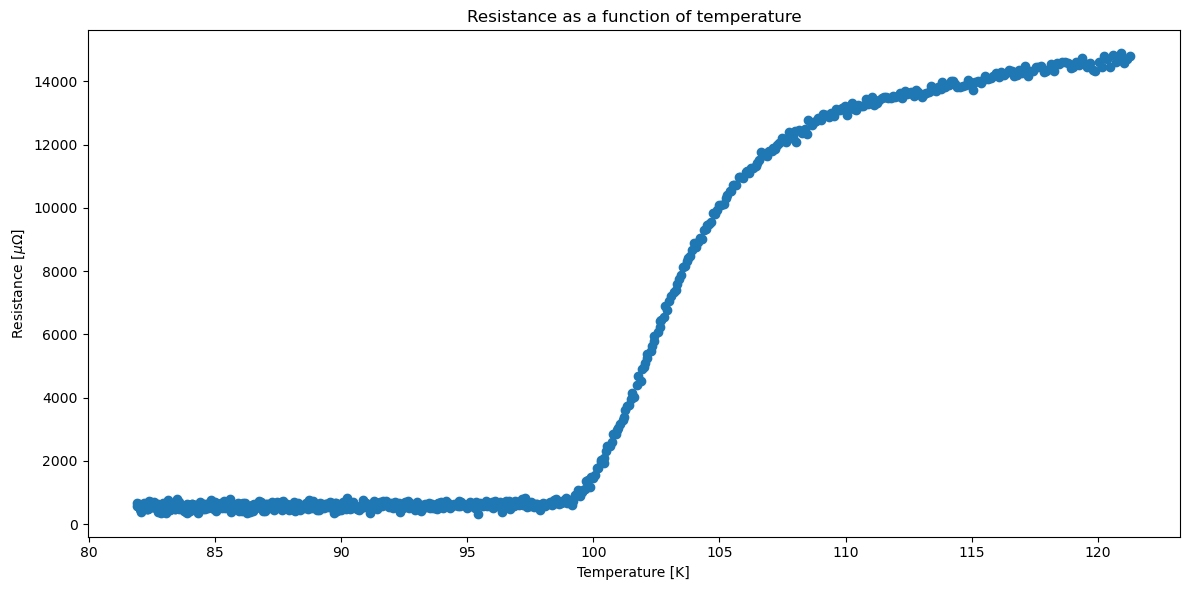

In [30]:
proeven_cooldown = get_data_from_file('data_superconductor/cooldown_5milli.txt')

remove_bad_datapoints(proeven_cooldown)
print('rescaled temp')
plot_const_current(proeven_cooldown, ylogscale = False)

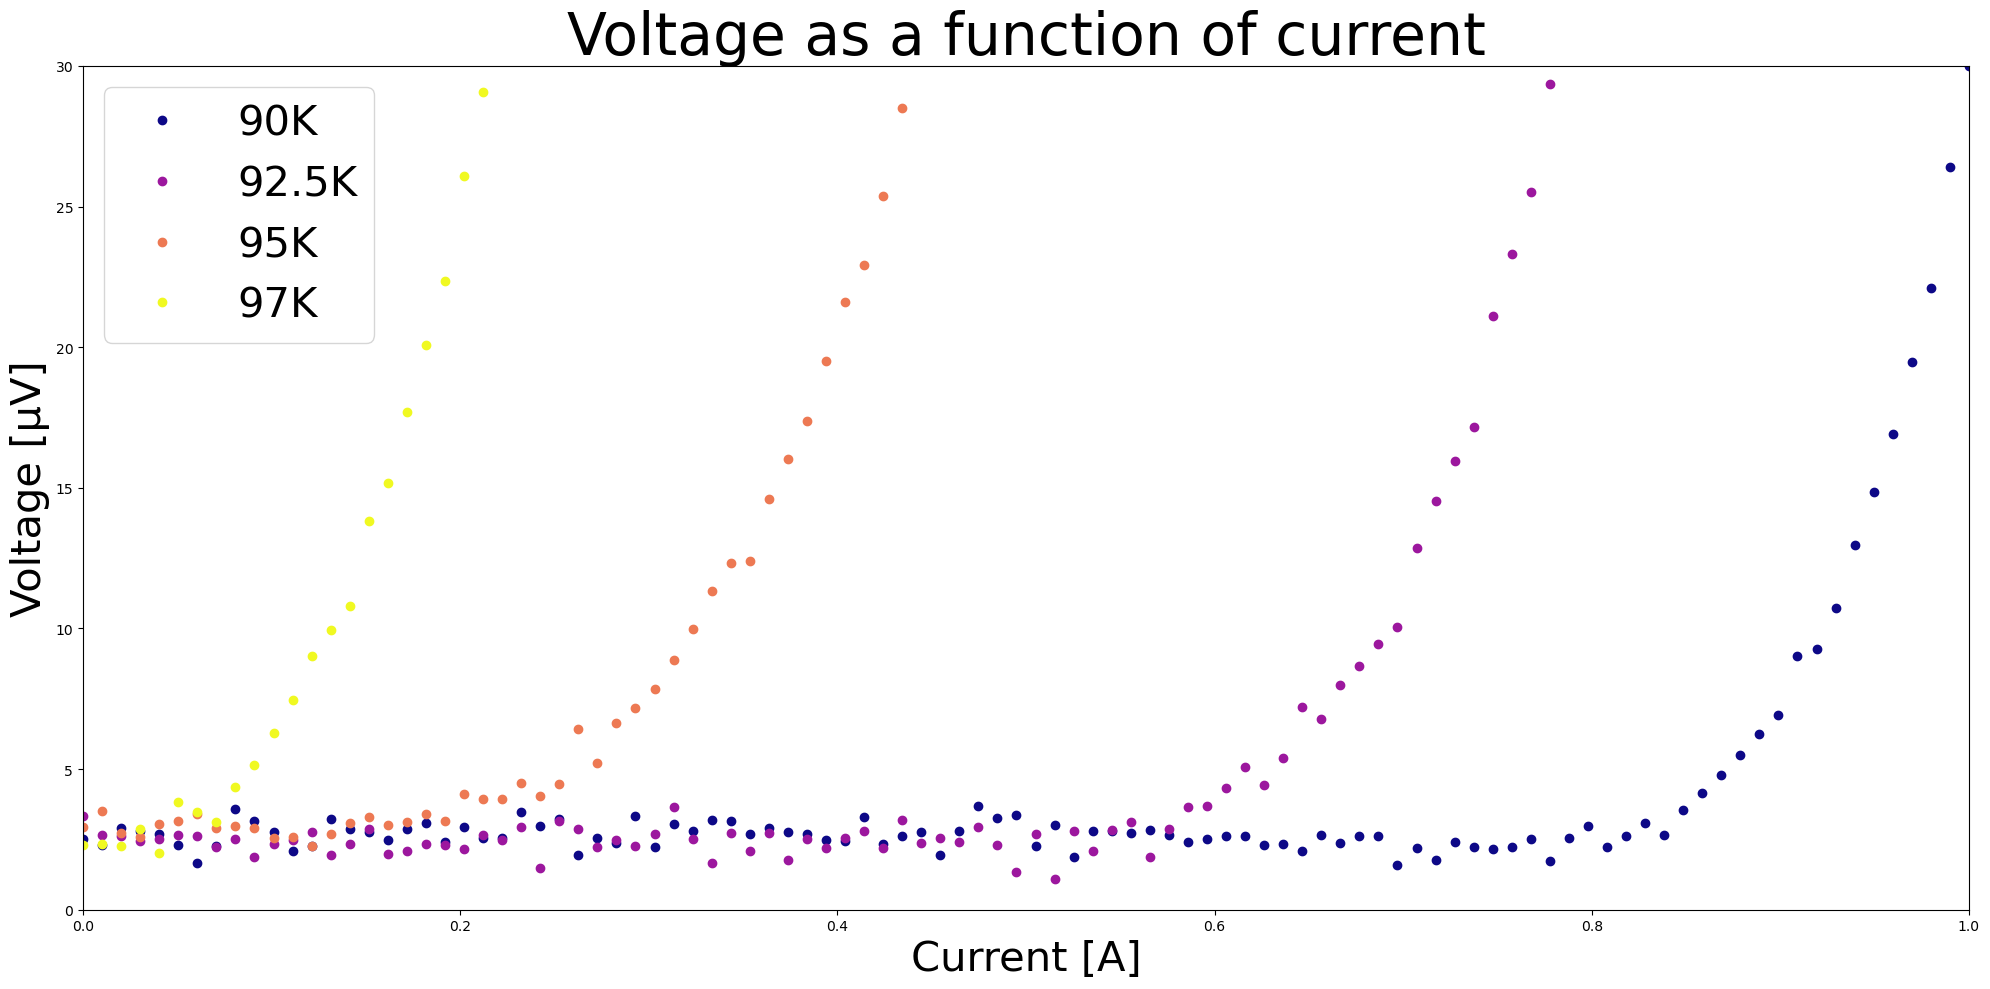

In [49]:
temperaturen = [90, '92,5',95, 97] #110, 104, 102, 95
def decimalpoint(inp):
    return str(inp).replace(',','.')
temperaturenlegende = [decimalpoint(temp) for temp in temperaturen]
proeven_vaste_temp = [get_data_from_file('data_superconductor/long_sweep-'+str(temp)+'.txt') for temp in temperaturen]
plot_const_multiple_Temp(proeven_vaste_temp, temperaturenlegende, 'Voltage', nulspanning=0, ylogscale=False, figsize = (20,10), xlim = (0,1), ylim = (0, 30))

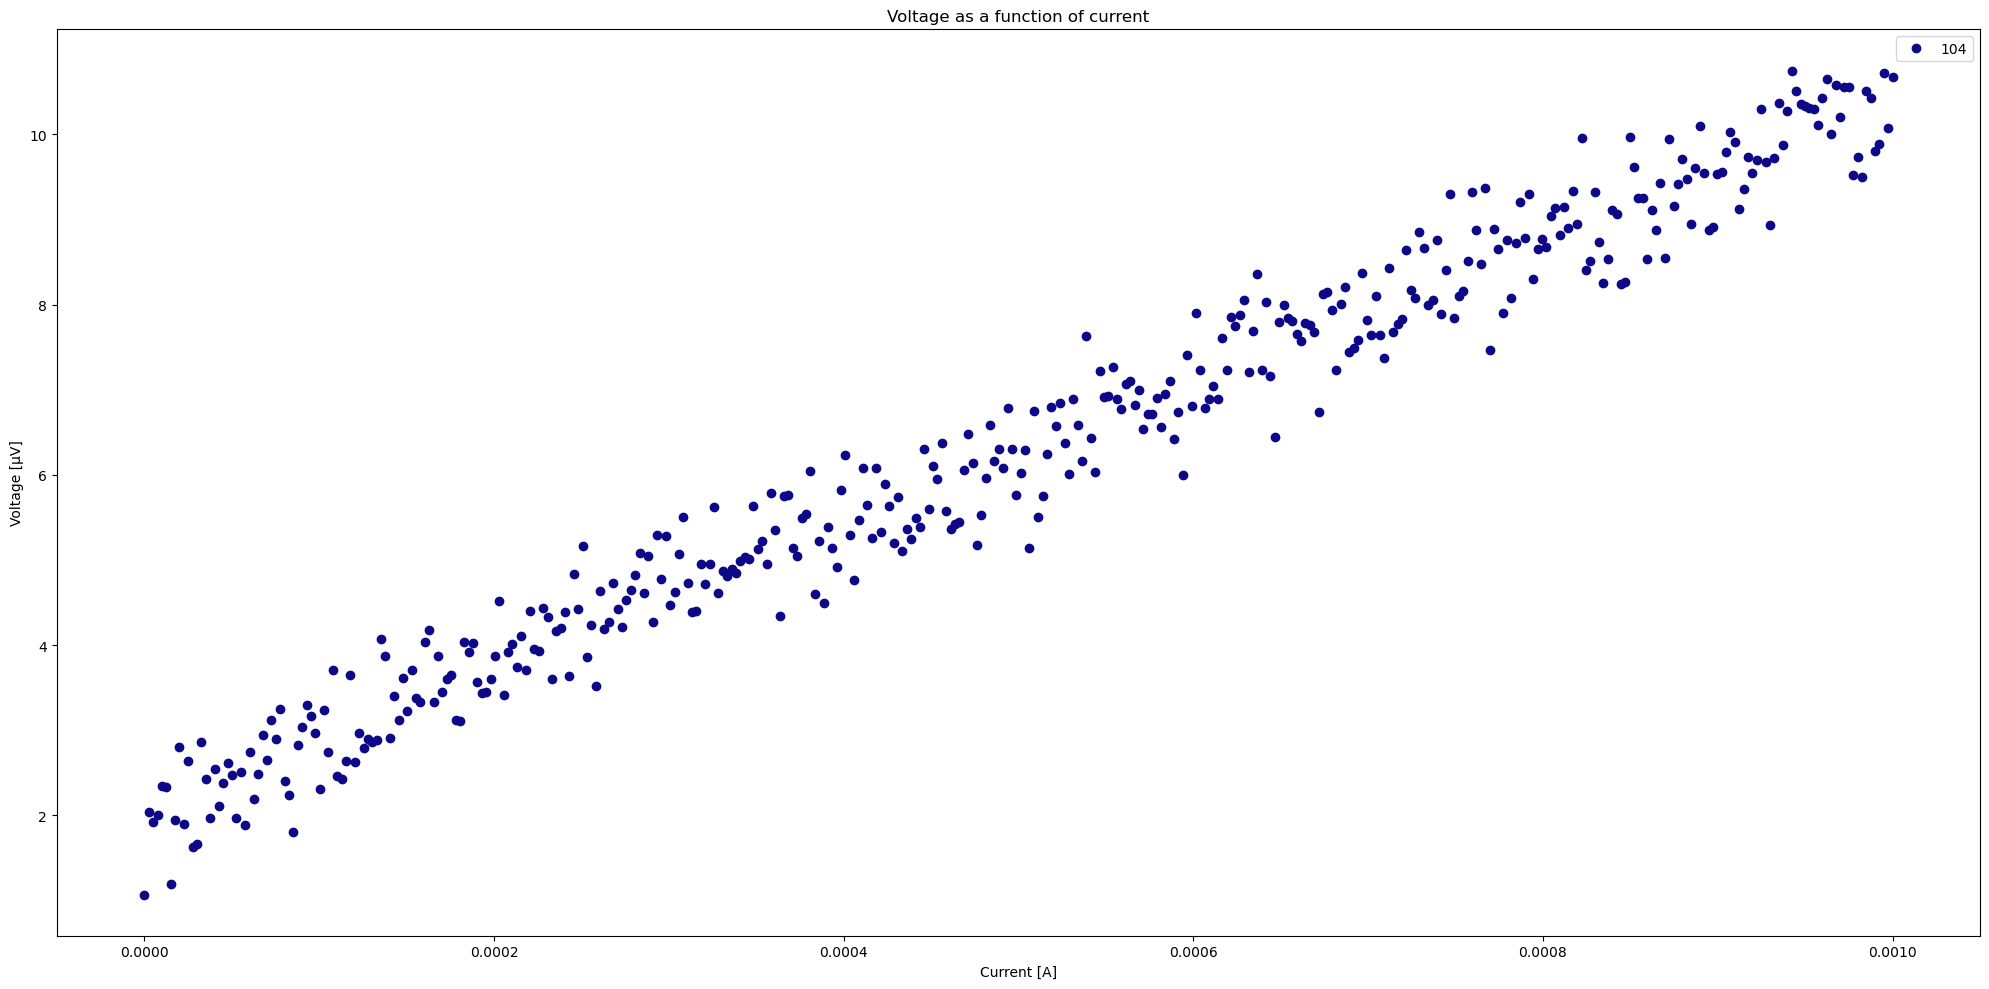

In [32]:
temperaturen = [104] #99
def decimalpoint(inp):
    return str(inp).replace(',','.')
temperaturenlegende = [decimalpoint(temp) for temp in temperaturen]
proeven_vaste_temp = [get_data_from_file('data_superconductor/fine_sweep-'+str(temp)+'.txt') for temp in temperaturen]
plot_const_multiple_Temp(proeven_vaste_temp, temperaturenlegende, 'Voltage', nulspanning=0, ylogscale=False, figsize = (20,10))#, xlim = (0,0.2), ylim = (0, 20))

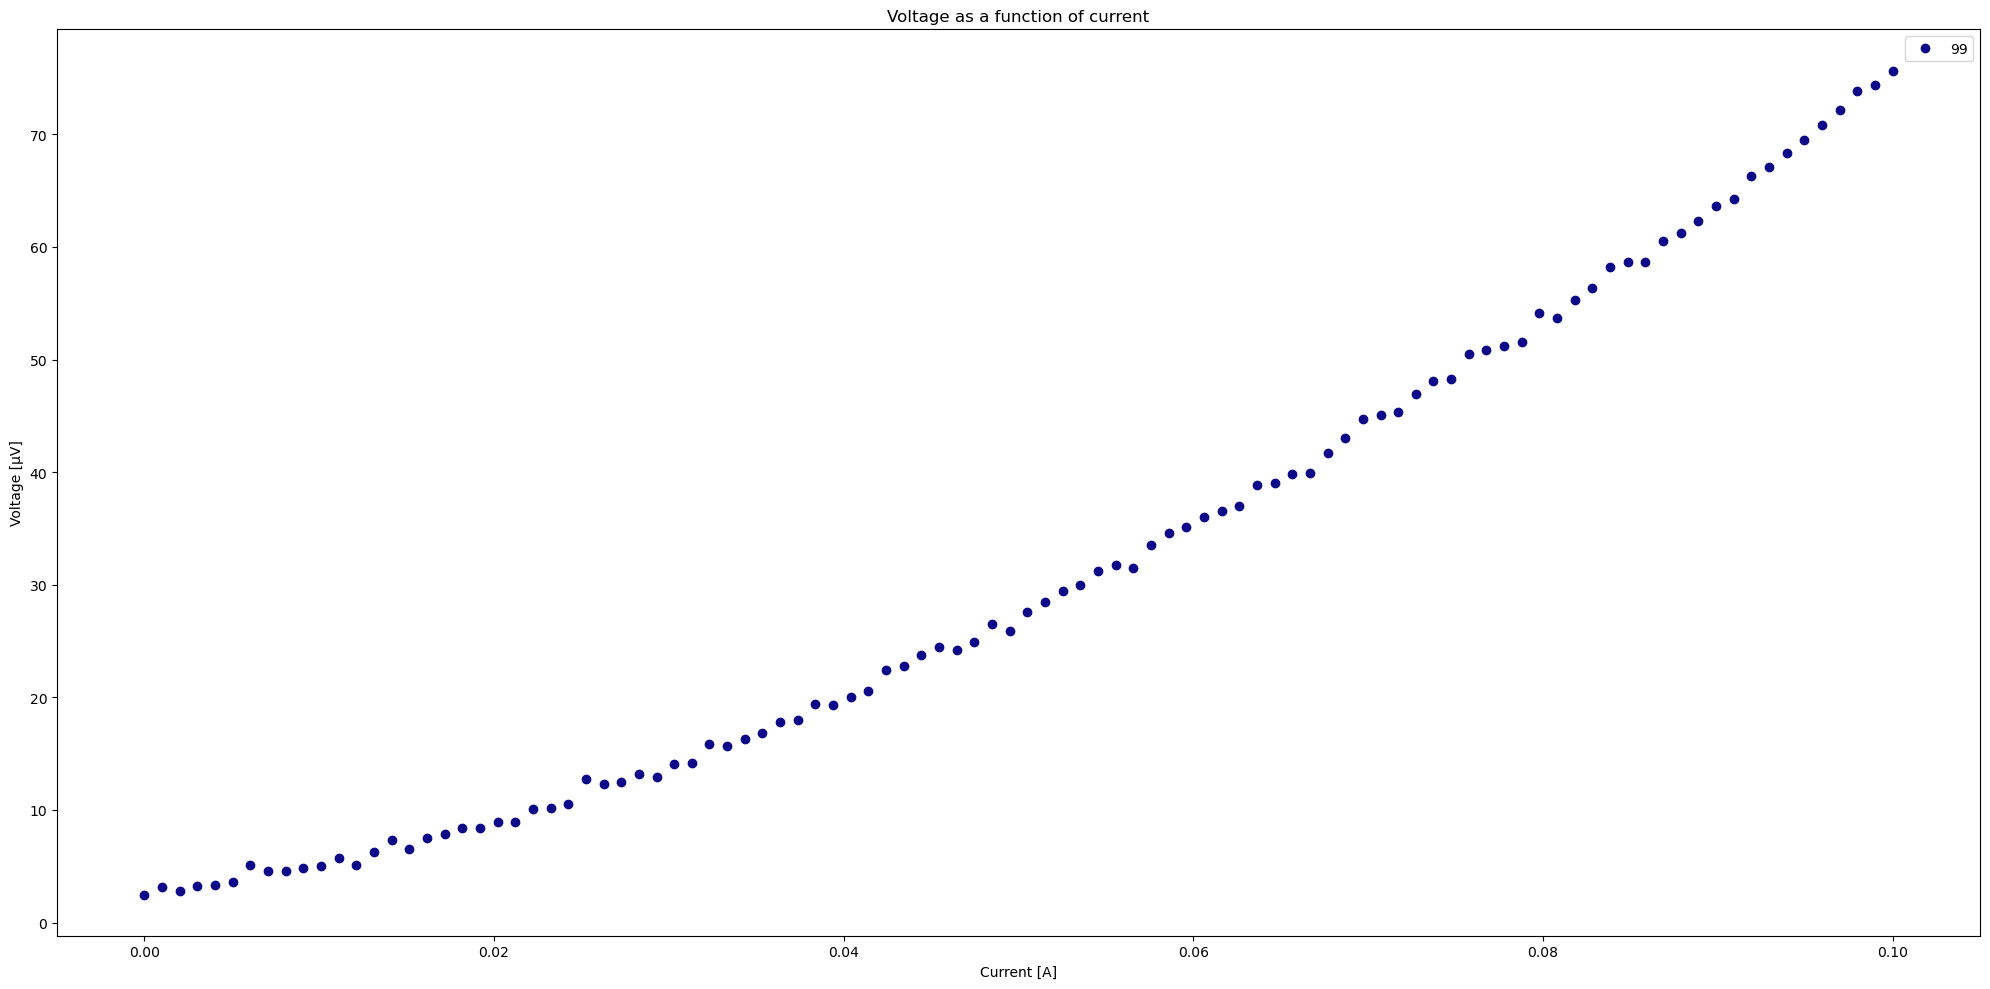

In [33]:
temperaturen = [99]
def decimalpoint(inp):
    return str(inp).replace(',','.')
temperaturenlegende = [decimalpoint(temp) for temp in temperaturen]
proeven_vaste_temp = [get_data_from_file('data_superconductor/coarse_sweep-'+str(temp)+'.txt') for temp in temperaturen]
plot_const_multiple_Temp(proeven_vaste_temp, temperaturenlegende, 'Voltage', nulspanning=0, ylogscale=False, figsize = (20,10))#, xlim = (0,0.2), ylim = (0, 20))